In [1]:
from DataFolder import DataFolder
from Signal import Signal

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import emd

from bycycle.features import compute_features

# Configuration

In [2]:
INPUT_DIR = "/home/miranjo/common-datasets/LFP_CBD/rem/"

# Filter settings
f_theta = (4, 12)
f_lowpass = 25
n_seconds_filter = .5  # could be changed to 0.1
n_seconds_theta = .75
fs = 2500

#Bycycle threshold settings
threshold_kwargs = {'amp_fraction_threshold': 0.8,
                        'amp_consistency_threshold': 0,
                        'period_consistency_threshold': 0,
                        'monotonicity_threshold': 0,
                        'min_n_cycles': 8}

# Setting up

In [3]:
def compute_range(x):
    return x.max() - x.min()

def asc2desc(x):
    """Ascending to Descending ratio ( A / A+D )."""
    pt = emd.cycles.cf_peak_sample(x, interp=True)
    tt = emd.cycles.cf_trough_sample(x, interp=True)
    if (pt is None) or (tt is None):
        return np.nan
    asc = pt + (len(x) - tt)
    desc = tt - pt
    return asc / len(x)

def peak2trough(x):
    """Peak to trough ratio ( P / P+T )."""
    des = emd.cycles.cf_descending_zero_sample(x, interp=True)
    if des is None:
        return np.nan
    return des / len(x)


In [4]:
remFolder = DataFolder(INPUT_DIR)
print(remFolder)

DataFolder in '/home/miranjo/common-datasets/LFP_CBD/rem/', contains 102 files.


In [5]:
sample = remFolder[3]
lfpREM = sample["data"][0]
metadata = sample["metadata"]

# Single signal analysis

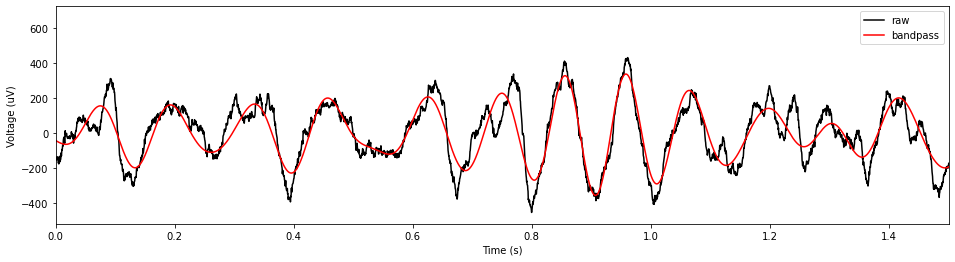

Sampling rate: 2500 Hz
Duration: 122.20 seconds
Max value: 665.82 uV
Min value: -461.92 uV
Mean value: -0.00 uV
Standard Deviation: 159.80 uV
Signal Range: 1127.73 uV
Number of Data Points: 305495


In [6]:
sig = Signal(lfpREM, fs)
sig.filter('bandpass', f_theta, n_seconds_theta)
sig.plot(xlim=(0, 1.5))
sig.summary()

In [7]:
metadata

{'RatID': 'Rat4',
 'StudyDay': 'SD9',
 'condition': 'HC',
 'condition_full': 'HomeCage',
 'treatment': 'TreatmentNegative',
 'posstrial_number': 'posttrial3'}

## Cycle-by-Cycle analysis

### We first detect phasic and tonic periods from the signal

In [8]:
# Detect phasic and tonic periods
df_byc = compute_features(sig.filtered, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')

#Extract Phasic and Tonic states
df_theta_phasic = df_byc[df_byc['is_burst']]
df_theta_tonic  = df_byc[df_byc['is_burst' ] == False]

result_msg = "{} periods in the {} signal: {}"

print(result_msg.format("Phasic", sig.filter_type, len(df_theta_phasic)))
print(result_msg.format("Tonic", sig.filter_type, len(df_theta_tonic)))


df_byc_2 = compute_features(sig.raw_signal, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')
phasic_raw = len( df_byc_2[df_byc_2['is_burst']])
tonic_raw = len(df_byc_2[df_byc_2['is_burst' ] == False])

print(result_msg.format("Phasic", "raw", phasic_raw))
print(result_msg.format("Tonic", "raw", tonic_raw))


Phasic periods in the bandpass signal: 47
Tonic periods in the bandpass signal: 865
Phasic periods in the raw signal: 20
Tonic periods in the raw signal: 893


In [9]:
# Peak to Trough ratio for Bycyle Cycle
p = df_theta_phasic.time_peak
t = df_theta_phasic.time_trough
p2t_phasic = p/(p+t)

# Peak to Trough ratio for Bycyle Cycle
p = df_theta_tonic.time_peak
t = df_theta_tonic.time_trough
p2t_tonic = p/(p+t)

# Ascending to Descending ratio for Bycyle Cycle
A = df_theta_phasic.time_rise
D = df_theta_phasic.time_decay
asc2desc_phasic = A/(A+D)

# Ascending to Descending ratio for Bycyle Cycle
A = df_theta_tonic.time_rise
D = df_theta_tonic.time_decay
asc2desc_tonic = A/(A+D)

In [10]:
def plot_hist(feature, bins='auto', ax=None, **kwargs):

    # Default keyword args
    figsize = kwargs.pop('figsize', (5, 5))
    xlabel = kwargs.pop('xlabel', None)
    xlim = kwargs.pop('xlim', None)
    ylim = kwargs.pop('ylim', None)
    fontsize = kwargs.pop('fontsize', 15)
    alpha = kwargs.pop('alpha', .7)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    # Axis style
    ax.set_xlabel(xlabel, size=fontsize)
    ax.set_ylabel('# cycles', size=fontsize)

    if xlim is not None:
        ax.set_xlim(xlim)

    if ylim is not None:
        ax.set_xlim(ylim)
        
    ax.hist(feature, bins=bins, alpha=alpha, **kwargs)
    

## Phasic vs Tonic features histogram

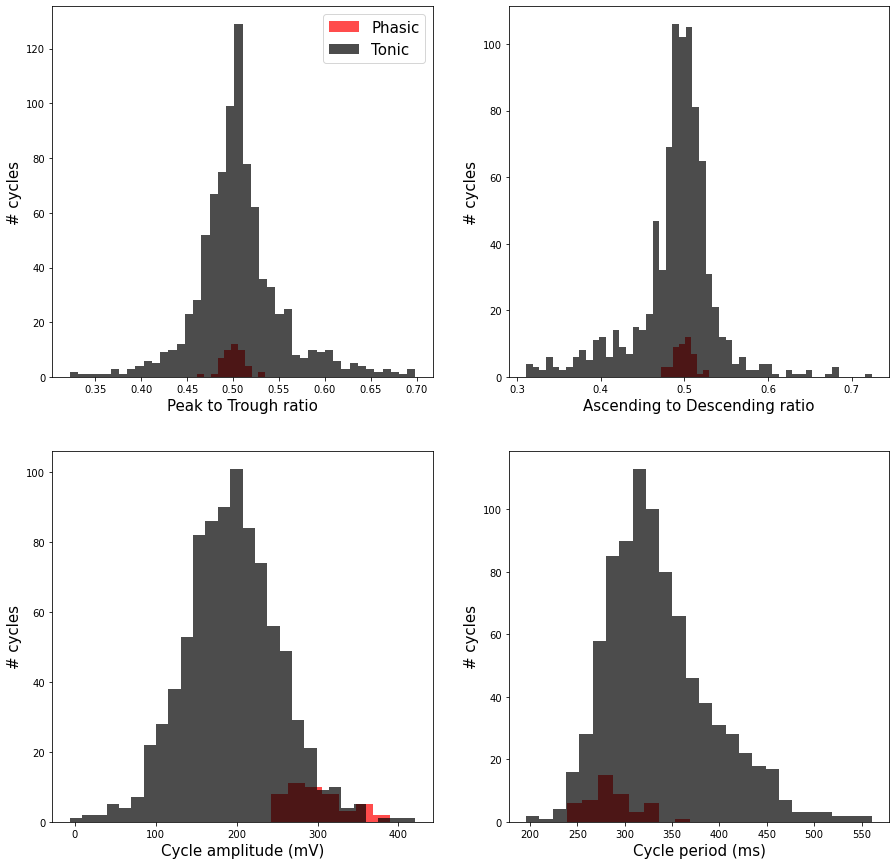

In [11]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)

# Peak to trough ratio
dist1 = p2t_phasic
dist2 = p2t_tonic

plot_hist(dist1, ax=axes[0][0], xlabel="Peak to Trough ratio", color='r')
plot_hist(dist2, ax=axes[0][0], xlabel="Peak to Trough ratio", color='k')

axes[0][0].legend(['Phasic', 'Tonic'], fontsize=15)

# Ascending to descending ratio
dist1 = asc2desc_phasic
dist2 = asc2desc_tonic

plot_hist(dist1, ax=axes[0][1], xlabel="Ascending to Descending ratio", color='r')
plot_hist(dist2, ax=axes[0][1], xlabel="Ascending to Descending ratio", color='k')

# Max amplitude
dist1 = df_theta_phasic['volt_peak']
dist2 = df_theta_tonic['volt_peak']

plot_hist(dist1, ax=axes[1][0], xlabel="Cycle amplitude (mV)", color='r')
plot_hist(dist2, ax=axes[1][0], xlabel="Cycle amplitude (mV)", color='k')

# Duration of samples
dist1 = df_theta_phasic['time_rise'] + df_theta_phasic['time_decay']
dist2 = df_theta_tonic['time_rise'] + df_theta_tonic['time_decay']

plot_hist(dist1, ax=axes[1][1], xlabel="Cycle period (ms)", color='r')
plot_hist(dist2, ax=axes[1][1], xlabel="Cycle period (ms)", color='k')

## EMD analysis

In [12]:
IP, IF, IA = emd.spectra.frequency_transform(sig.filtered, fs, 'hilbert', smooth_phase=3)

C = emd.cycles.Cycles(IP.flatten())
print("Detected cycles before extraction:")
print(C)

# computing the cycle metrics 
C.compute_cycle_metric('start_sample', np.arange(len(C.cycle_vect)), emd.cycles.cf_start_value)
C.compute_cycle_metric('stop_sample', sig.filtered, emd.cycles.cf_end_value)
C.compute_cycle_metric('peak_sample', sig.filtered, emd.cycles.cf_peak_sample)
C.compute_cycle_metric('desc_sample', sig.filtered, emd.cycles.cf_descending_zero_sample)
C.compute_cycle_metric('trough_sample', sig.filtered, emd.cycles.cf_trough_sample)
C.compute_cycle_metric('duration_samples', sig.filtered, len)

C.compute_cycle_metric('max_amp', IA, np.max)
C.compute_cycle_metric('mean_if', IF, np.mean)
C.compute_cycle_metric('max_if', IF, np.max)
C.compute_cycle_metric('range_if', IF, compute_range)

C.compute_cycle_metric('asc2desc', sig.filtered, asc2desc)
C.compute_cycle_metric('peak2trough', sig.filtered, peak2trough)

print('\nFinished computing the cycles metrics\n')

# Extract subset of the cycles 
amp_thresh = np.percentile(IA, 25)
lo_freq_duration = fs/5
hi_freq_duration = fs/12
conditions = ['is_good==1',
              f'duration_samples<{lo_freq_duration}',
              f'duration_samples>{hi_freq_duration}',
              f'max_amp>{amp_thresh}']

C.pick_cycle_subset(conditions)
print("Cycles after extraction:")
print(C)


Detected cycles before extraction:
<class 'emd.cycles.Cycles'> (913 cycles 1 metrics) 

Finished computing the cycles metrics

Cycles after extraction:
<class 'emd.cycles.Cycles'> (913 cycles 838 subset 52 chains - 14 metrics) 


In [16]:
df_emd = C.get_metric_dataframe()
df_emd

,is_good,start_sample,stop_sample,peak_sample,desc_sample,trough_sample,duration_samples,max_amp,mean_if,max_if,range_if,asc2desc,peak2trough,chain_ind
0,0,0,-1.440225,None,None,42.540006,102,114.958779,2.277854,7.348341,47.700777,NaN,NaN,-1
1,1,102,-0.833156,85.248573,154.228228,231.148985,309,198.939084,8.102122,8.306203,0.931978,0.527830,0.499120,0
2,1,411,-1.407481,70.662014,157.199199,242.182411,332,188.772912,7.520719,8.009581,1.050018,0.483372,0.473492,0
3,1,743,-2.755998,92.056632,164.675676,246.467745,325,232.916431,7.692152,7.848703,0.694283,0.524889,0.506694,0
4,1,1068,-2.414284,74.361087,173.485485,332.551082,409,229.232140,6.109849,7.719058,3.858917,0.368729,0.424170,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,1,303534,-1.674010,88.882003,176.633634,260.736279,345,163.299226,7.240469,7.534917,0.734507,0.501872,0.511982,51
909,1,303879,-2.333841,94.448266,188.984985,285.494144,366,247.173720,6.832369,7.507808,1.163205,0.478017,0.516352,51
910,0,304245,-1.139183,74.565549,167.598599,395.19365,471,246.915681,5.309432,7.572188,14.509878,0.319261,0.355836,-1
911,1,304716,-2.263193,87.484149,219.031031,335.683489,434,166.592598,5.752820,6.928294,2.163210,0.428112,0.504680,52


In [13]:
df_byc = compute_features(sig.filtered, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')

#Extract Phasic and Tonic states
df_theta_phasic = df_byc[df_byc['is_burst']]
df_theta_tonic  = df_byc[df_byc['is_burst' ] == False]

## EMD vs Cycle by Cycle feature histogram

In [14]:
# Peak to Trough ratio for Bycyle Cycle
p = df_byc.time_peak
t = df_byc.time_trough
p2t = p/(p+t)

# Ascending to Descending ratio for Bycyle Cycle
A = df_byc.time_rise
D = df_byc.time_decay
asc2desc = A/(A+D)

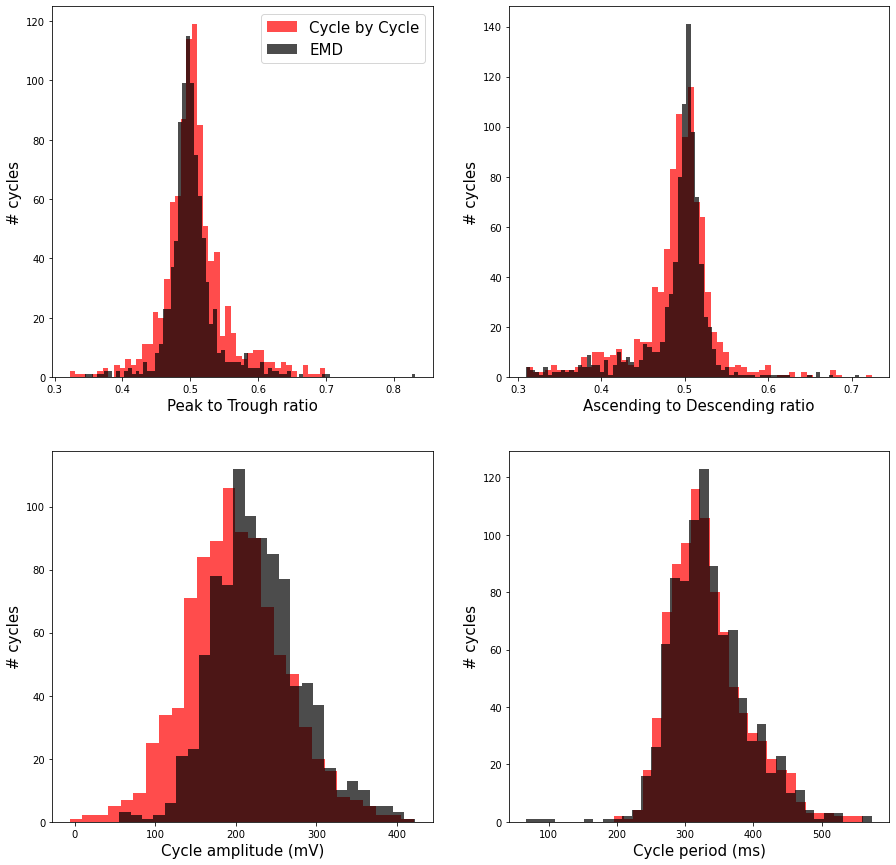

In [19]:
fig, axes = plt.subplots(figsize=(15, 15), nrows=2, ncols=2)

# Peak to trough ratio
dist1 = p2t
dist2 = df_emd['peak2trough']

plot_hist(dist1, ax=axes[0][0], xlabel="Peak to Trough ratio", color='r')
plot_hist(dist2, ax=axes[0][0], xlabel="Peak to Trough ratio", color='k')

axes[0][0].legend(['Cycle by Cycle', 'EMD'], fontsize=15)

# Ascending to descending ratio
dist1 = asc2desc
dist2 = df_emd['asc2desc']

plot_hist(dist1, ax=axes[0][1], xlabel="Ascending to Descending ratio", color='r')
plot_hist(dist2, ax=axes[0][1], xlabel="Ascending to Descending ratio", color='k')

# Max amplitude
dist1 = df_byc['volt_peak']
dist2 = df_emd['max_amp']

plot_hist(dist1, ax=axes[1][0], xlabel="Cycle amplitude (mV)", color='r')
plot_hist(dist2, ax=axes[1][0], xlabel="Cycle amplitude (mV)", color='k')

# Duration of samples
dist1 = df_byc['time_rise'] + df_byc['time_decay']
dist2 = df_emd['duration_samples']

plot_hist(dist1, ax=axes[1][1], xlabel="Cycle period (ms)", color='r')
plot_hist(dist2, ax=axes[1][1], xlabel="Cycle period (ms)", color='k')

# Running the analysis on all dataset

In [22]:
from neurodsp.filt import filter_signal

for rem in remFolder:
    for sig in rem["data"]:
        sig_filt = filter_signal(sig, fs, "bandpass", f_theta, n_seconds=n_seconds_theta, remove_edges=False)
        df = compute_features(sig_filt, fs, f_range=f_theta, threshold_kwargs=threshold_kwargs, center_extrema='peak')

        # Extract Phasic and Tonic states
        df_theta_phasic = df_byc[df_byc['is_burst']]
        df_theta_tonic  = df_byc[df_byc['is_burst' ] == False]

        # Calculations
        pass

        

{'data': [array([-271.11647791, -224.58651607, -218.49361963, ...,  230.92286555,
        229.36716252,  207.59756128]), array([  75.44283995,   58.57216937,  139.112792  , ..., -118.06920637,
       -142.82925072, -111.70387854])], 'metadata': {'RatID': 'Rat5', 'StudyDay': 'SD5', 'condition': 'OD', 'condition_full': 'ObjectSpace', 'treatment': 'TreatmentPositive', 'posstrial_number': 'posttrial4'}}
